<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/siamesenet_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
tf.__version__

'2.12.0'

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [12]:
x_train = np.reshape(x_train, (60000,784))

In [13]:
x_test = np.reshape(x_test,(10000,784))
# scale*inputs+offset
# tf.keras.layers.Rescaling(scale=1/255.0, offset=0.0) --(0, 255)
# tf.keras.layers.Rescaling(scale=1/127.5, offset=-1.0) -- (-1,1)

In [17]:
def plot_triplet(triplet):
  plt.figure(figsize=(6,2))
  for i in range(0,3):
    plt.subplot(1,3, i+1)
    plt.imshow(np.reshape(triplet[i],(28,28)), cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()

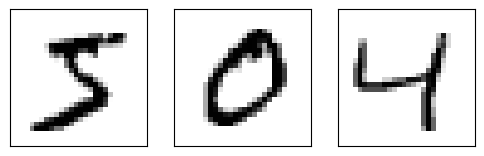

In [18]:
plot_triplet([x_train[0], x_train[1], x_train[2]])

In [19]:
from sklearn.decomposition import PCA

class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
        
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)


Create triplet batch

In [36]:
def create_batch(batch_size):
  anchors = np.zeros((batch_size, 784))
  positives = np.zeros((batch_size, 784))
  negatives = np.zeros((batch_size, 784))

  for i in range(0, batch_size):
    index = random.randint(0,60000-1) # get a random image among 60,000 training samples
    anc = x_train[index]
    y = y_train[index] # get the label of the random picked image

    indices_for_pos = np.squeeze(np.where(y_train==y)) # get rid of the second element of the tuple
    indices_for_neg = np.squeeze(np.where(y_train!=y))

    # pick one positive example
    pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
    # pick one negative example
    neg = x_train[indices_for_neg[random.randint(0, len(indices_for_pos)-1)]]

    anchors[i] = anc
    positives[i] = pos
    negatives[i] = neg
    
  return [anchors, positives, negatives]

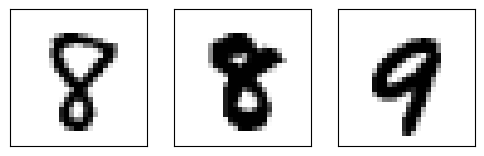

In [40]:
triplet = create_batch(1)
plot_triplet(triplet)

Build embedding model

In [42]:
emb_dim = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [43]:
example = x_train[0]
example_embedding = embedding_model.predict(np.expand_dims(example, axis=0))
print(example_embedding.shape)

1/1 [==============================] - 3s 3s/step
(1, 64)


Build the siamese net

In [45]:
anc_input = tf.keras.layers.Input(shape=(784,))
pos_input = tf.keras.layers.Input(shape=(784,))
neg_input = tf.keras.layers.Input(shape=(784,))

em_anc = embedding_model(anc_input)
em_pos = embedding_model(pos_input)
em_neg = embedding_model(neg_input)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1) # cat in the 2nd dimension - column wise
net = tf.keras.models.Model(inputs=[anc_input, pos_input, neg_input], outputs=out)

In [46]:
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           54400       ['input_4[0][0]',                
                                                                  'input_5[0][0]',            

define the triplet loss

In [47]:
def triplet_loss(alpha, emb_dim):
  def loss(y_true, y_pred):
    anc, pos, neg = y_pred[:,:emb_dim], y_pred[:,emb_dim:2*emb_dim], y_pred[:,2*emb_dim:]
    dis_pos = tf.reduce_mean(tf.square(anc-pos), axis=1)
    dis_neg = tf.reduce_mean(tf.square(anc-neg), axis=1)
    loss_value = tf.maximum(dis_pos - dis_neg + alpha, 0.0)
    return loss_value

  return loss

Create Data Generator

In [48]:
def data_generator(batch_size, emb_dim):
  while True:
    x = create_batch(batch_size)
    y = np.zeros((batch_size, 3*emb_dim))
    yield x, y

Model training

In [50]:
batch_size =256
epochs = 10
steps_per_epoch = int(60000/batch_size)

net.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_dim), optimizer='adam')

X, Y = x_test[:1000], y_test[:1000]

32/32 [==============================] - 0s 1ms/step
Epoch 1/10
32/32 [==============================] - 0s 2ms/step
234/234 - 23s - loss: 0.0655 - 23s/epoch - 98ms/step
Epoch 2/10
32/32 [==============================] - 0s 2ms/step
234/234 - 20s - loss: 0.0365 - 20s/epoch - 84ms/step
Epoch 3/10
32/32 [==============================] - 0s 2ms/step
234/234 - 22s - loss: 0.0286 - 22s/epoch - 93ms/step
Epoch 4/10
32/32 [==============================] - 0s 2ms/step
234/234 - 22s - loss: 0.0230 - 22s/epoch - 95ms/step
Epoch 5/10
32/32 [==============================] - 0s 3ms/step
234/234 - 20s - loss: 0.0192 - 20s/epoch - 86ms/step
Epoch 6/10
32/32 [==============================] - 0s 2ms/step
234/234 - 20s - loss: 0.0168 - 20s/epoch - 86ms/step
Epoch 7/10
32/32 [==============================] - 0s 2ms/step
234/234 - 20s - loss: 0.0151 - 20s/epoch - 88ms/step
Epoch 8/10
32/32 [==============================] - 0s 2ms/step
234/234 - 20s - loss: 0.0134 - 20s/epoch - 84ms/step
Epoch 9/10


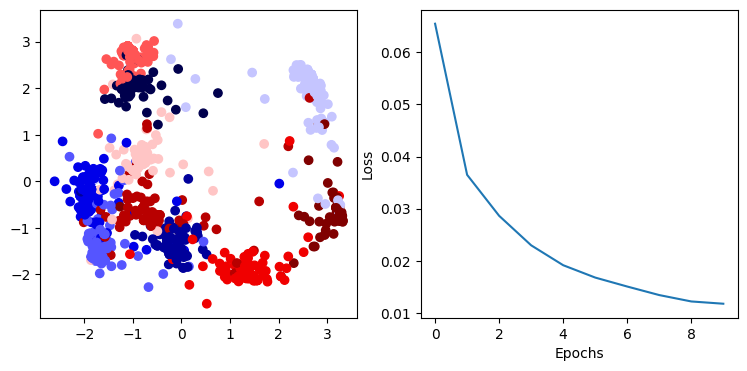

In [51]:
history = net.fit(data_generator(batch_size=batch_size, emb_dim=emb_dim), epochs=epochs, steps_per_epoch=steps_per_epoch, 
                  callbacks=[PCAPlotter(plt, embedding_model, X, Y)], verbose=2)